In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import *

Using TensorFlow backend.


In [3]:
sess = tf.Session()

In [82]:
img = np.zeros((1, 100,100,3))
img[:, 40:60, 40:60, :]=1

img[:, 30:40, 1:10, :]=1

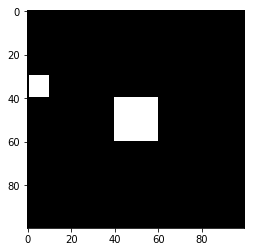

In [83]:
plt.imshow(img[0])
plt.show()

In [84]:
boxes = np.array([[0.4, 0.4, 0.6, 0.6],
                 [0.3, 0.01, 0.4, 0.1]])
boxes = np.expand_dims(boxes, 0)
boxes.shape

(1, 2, 4)

In [85]:
boxed_img = tf.image.draw_bounding_boxes(img, boxes)
boxed_img = sess.run(boxed_img)

In [86]:
boxed_img.dtype

dtype('float32')

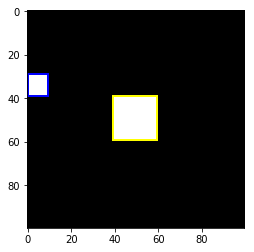

In [87]:
plt.imshow(boxed_img[0,:,:])

In [88]:
# look at boxes for one image
boxes = boxes.reshape(-1, 4)

num_boxes = boxes.shape[0]
# look at the four vertices of each box
up_left = boxes[:, :2] # xmin, ymin
down_right = boxes[:, 2:] # xmax, ymax
down_left = np.concatenate([boxes[:,0], boxes[:,-1]], axis=-1) # xmin, ymax
down_left = down_left.reshape((-1, 2))
up_right = np.concatenate([boxes[:,3], boxes[:,1]], axis=-1) # xmax, ymin
up_right = up_right.reshape((-1, 2))

x_min = boxes[:, 0]
y_min = boxes[:, 1]
x_max = boxes[:, 2]
y_max = boxes[:, 3]

# create new axis to stack the x,y coordinates
x_min = np.expand_dims(x_min, axis=-1)
y_min = np.expand_dims(y_min, axis=-1)
x_max = np.expand_dims(x_max, axis=-1)
y_max = np.expand_dims(y_max, axis=-1)

# stack the x,y coordinates to create the vertices
# the resulting arrays are indexed [idx of box, idx of x or y]
up_left = np.concatenate([x_min, y_min], axis=-1)
up_right = np.concatenate([x_min, y_max], axis=-1)
down_right = np.concatenate([x_max, y_max], axis=-1)
down_left = np.concatenate([x_max, y_min], axis=-1)

# now stack the vertices, along axis 1
up_left = np.expand_dims(up_left, axis=1)
up_right = np.expand_dims(up_right, axis=1)
down_right= np.expand_dims(down_right, axis=1)
down_left = np.expand_dims(down_left, axis=1)

# create an array of all vertices, of all boxes
# the shape is [number of boxes, number of vertices, number of coordinates]
# ->  shape is [number of boxes, 4, 2]
vecs = np.concatenate([up_left, up_right, down_right, down_left], axis=1)

In [89]:
up_left.shape

(2, 1, 2)

In [90]:
vecs.shape

(2, 4, 2)

In [91]:
vecs.reshape((num_boxes, 4, 2))[:,:,0]

array([[ 0.4,  0.4,  0.6,  0.6],
       [ 0.3,  0.3,  0.4,  0.4]])

In [92]:
import scipy.ndimage as ndi

In [103]:
# params
fill_mode = "nearest"
cval = 0
channel_axis = 0
rg = 10

In [104]:
# sample a rotation matrix
theta = np.pi / 180 * np.random.uniform(-rg, rg)
theta = np.pi / 180 * 15
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])

In [105]:
# apply to bounding box vectors
h, w = 0.5, 0.5
transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
#vecs = apply_transform(vecs, transform_matrix_vecs, channel_axis, fill_mode, cval)

final_affine_matrix = transform_matrix[:2, :2]
final_offset = transform_matrix[:2, 2]

vec_rotation_matrix = rotation_matrix[:2, :2]

In [106]:
new_vecs = vecs.copy()
new_vecs = new_vecs.reshape((-1, 2))
new_vecs -= [0.5, 0.5]
new_vecs = np.dot(new_vecs, vec_rotation_matrix)
new_vecs += [0.5, 0.5]

new_vecs = new_vecs.reshape((num_boxes, 4, 2))
x = new_vecs[:,:,0]
y = new_vecs[:,:,1]
x_min = x.min(axis=-1)
x_max = x.max(axis=-1)
y_min = y.min(axis=-1)
y_max = y.max(axis=-1)

x_min = np.expand_dims(x_min, axis=-1)
x_max = np.expand_dims(x_max, axis=-1)
y_min = np.expand_dims(y_min, axis=-1)
y_max = np.expand_dims(y_max, axis=-1)

new_boxes = np.concatenate([x_min, y_min, x_max, y_max], axis=-1)

In [107]:
new_boxes = np.expand_dims(new_boxes, axis=0)

num_boxes = vecs.shape[0]//4
up_left = vecs[:num_boxes]
down_right = vecs[num_boxes:num_boxes*2]
down_left = vecs[num_boxes*2:num_boxes*3]
up_right = vecs[num_boxes*3:num_boxes*4]

x1 = vec1[:,0].reshape((-1,1))
x2 = vec2[:,0].reshape((-1,1))
x3 = vec3[:,0].reshape((-1,1))
x4 = vec4[:,0].reshape((-1,1))
x = np.concatenate([x1, x2, x3, x4], axis=-1)
xmin = np.min(x, axis=-1)
xmax = np.max(x, axis=-1)

y1 = vec1[:,1].reshape((-1,1))
y2 = vec2[:,1].reshape((-1,1))
y3 = vec3[:,1].reshape((-1,1))
y4 = vec4[:,1].reshape((-1,1))
y = np.concatenate([y1, y2, y3, y4], axis=-1)
ymin = np.min(y, axis=-1)
ymax = np.max(y, axis=1)

new_boxes = np.array([xmin, ymin, xmax, ymax])
new_boxes = new_boxes.reshape((1,1,4))
new_boxes

In [108]:
# apply to bounding box vectors
channel_axis= 2
row_axis = 0
col_axis = 1

x = img[0].copy()

h, w = x.shape[row_axis], x.shape[col_axis]
transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)

In [109]:
new_img = np.expand_dims(x,0)

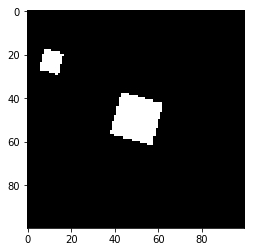

In [110]:
plt.imshow(new_img[0])

In [111]:
new_boxed_img = tf.image.draw_bounding_boxes(new_img, new_boxes)
new_boxed_img = sess.run(new_boxed_img)

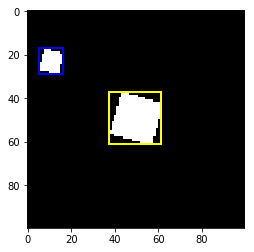

In [112]:
plt.imshow(new_boxed_img[0])